# Task 1 – Artificial Neural Network (ANN) Implementation
**Course:** Biologically-Inspired Computation (F20BC)  
**Student 1:** Muhammad Saad  
**Student 2:** Muhammad Hassan

**Objective:**  
Implement a configurable multi-layer feed-forward ANN from scratch.  
This notebook focuses on the *structure* and *forward propagation* only.  
Training will be performed later using Particle Swarm Optimisation (PSO).

In [1]:
# --- Section 1 : Imports ---
import numpy as np
from typing import Callable, List
# Optional (for visual checks later)
#import matplotlib.pyplot as plt

## Section 2 – Activation Functions
Activation functions introduce non-linearity into the ANN.  
The network will support:
- Sigmoid  
- ReLU  
- Tanh  
- Linear (for output layer in regression)

In [2]:
# --- Section 2 : Activation Functions ---

def sigmoid(x: np.ndarray) -> np.ndarray:
    """Numerically-stable sigmoid."""
    # clip for stability in exp
    x_clip = np.clip(x, -500, 500)
    return 1.0 / (1.0 + np.exp(-x_clip))

def relu(x: np.ndarray) -> np.ndarray:
    return np.maximum(0.0, x)

def tanh(x: np.ndarray) -> np.ndarray:
    # np.tanh is already stable/fast
    return np.tanh(x)

def linear(x: np.ndarray) -> np.ndarray:
    return x

# Map names to callables (keeps configuration simple)
ACTIVATIONS = {
    "sigmoid": sigmoid,
    "relu": relu,
    "tanh": tanh,
    "linear": linear,
}

def get_activation(name: str) -> Callable[[np.ndarray], np.ndarray]:
    name = name.lower()
    if name not in ACTIVATIONS:
        raise ValueError(f"Unknown activation '{name}'. Choose from {list(ACTIVATIONS.keys())}.")
    return ACTIVATIONS[name]

# quick shape test later
# print(sigmoid(np.array([-1,0,1])))

## Section 3 – Layer Class
Each layer stores its weights, biases, and activation function, and performs the computation   
*z = W · x + b ;  a = f(z)*.

In [3]:
# --- Section 3 : Layer Class ---

class Layer:
    """
    A fully-connected (dense) layer:
      z = W @ x + b
      a = activation(z)
    Supports vector input (shape: [in_dim]) and batch input (shape: [batch, in_dim]).
    """
    def __init__(self, input_size: int, output_size: int, activation: str, rng: np.random.Generator | None = None):
        self.input_size = input_size
        self.output_size = output_size
        self.activation_name = activation.lower()
        self.activation_fn = get_activation(self.activation_name)
        self.rng = rng if rng is not None else np.random.default_rng()

        # Weight initialization strategy:
        # - He init for ReLU
        # - Xavier/Glorot for tanh/sigmoid/linear
        if self.activation_name == "relu":
            # He initialization (Kaiming): N(0, sqrt(2/fan_in))
            scale = np.sqrt(2.0 / input_size)
        else:
            # Xavier/Glorot: N(0, sqrt(1/fan_in))
            scale = np.sqrt(1.0 / input_size)

        self.W = self.rng.normal(loc=0.0, scale=scale, size=(output_size, input_size)).astype(np.float64)
        self.b = np.zeros((output_size,), dtype=np.float64)

    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Forward pass through this layer.
        Accepts x with shape [in_dim] or [batch, in_dim].
        Returns a with shape [out_dim] or [batch, out_dim].
        """
        # Ensure 2D for unified math, then squeeze back if needed
        original_1d = False
        if x.ndim == 1:
            x = x[np.newaxis, :]   # [1, in_dim]
            original_1d = True

        # z = x @ W^T + b, but we store W as [out, in], so do x @ W.T
        z = x @ self.W.T + self.b  # [batch, out_dim]
        a = self.activation_fn(z)

        return a.squeeze(0) if original_1d else a

    def __repr__(self) -> str:
        return f"Layer(in={self.input_size}, out={self.output_size}, act='{self.activation_name}')"

# --- Test example ---
# layer = Layer(8, 10, 'relu')
# output = layer.forward(np.random.rand(8))
# print(output.shape)

## Section 4 – Neural Network Class
The network connects multiple layers and performs forward propagation through them.

In [4]:
# --- Section 4 : Neural Network Class ---

class NeuralNetwork:
    """
    A configurable feed-forward network composed of Layer objects.

    Example:
        architecture = [8, 10, 1]
        activations  = ['relu', 'linear']
    """
    def __init__(self, architecture: List[int], activations: List[str], seed: int | None = None):
        if len(architecture) < 2:
            raise ValueError("Architecture must have at least input and output sizes, e.g. [8, 1].")
        if len(activations) != len(architecture) - 1:
            raise ValueError(
                f"Need one activation per layer except input. "
                f"Got {len(activations)} activations for {len(architecture)-1} layers."
            )

        self.architecture = architecture
        self.activations = [a.lower() for a in activations]
        self.rng = np.random.default_rng(seed)

        # Build layers
        self.layers: List[Layer] = []
        for in_size, out_size, act in zip(architecture[:-1], architecture[1:], self.activations):
            self.layers.append(Layer(in_size, out_size, act, rng=self.rng))

    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Pass input through all layers.
        Accepts x shape [in_dim] or [batch, in_dim].
        Returns prediction with shape [out_dim] or [batch, out_dim].
        """
        out = x
        for layer in self.layers:
            out = layer.forward(out)
        return out

    # (Optional) convenience alias
    __call__ = forward

    def summary(self) -> None:
        """Print a concise model summary."""
        print("NeuralNetwork Summary")
        for idx, layer in enumerate(self.layers, start=1):
            print(f"  Layer {idx}: {layer}")
        print(f"Total layers (excluding input): {len(self.layers)}")

# --- Test example ---
# architecture = [8, 10, 1]
# activations  = ['relu', 'linear']
# nn = NeuralNetwork(architecture, activations)
# print(nn.forward(np.random.rand(8)))

## Section 5 – Configuration Flexibility
Demonstrate that the implementation can handle different architectures and activation combinations.

In [5]:
# --- Section 5 : Quick tests ---

# Baseline architecture for regression on Concrete dataset: 8 -> 10 -> 1
architecture = [8, 10, 1]
activations  = ['relu', 'linear']  # linear output for regression

nn = NeuralNetwork(architecture, activations, seed=42)
nn.summary()

# Single sample (vector) test
x_single = np.random.default_rng(0).random(8)  # shape [8]
y_single = nn.forward(x_single)
print("\nSingle-sample output:", y_single, " | shape:", np.shape(y_single))

# Batch test
x_batch = np.random.default_rng(1).random((5, 8))  # 5 samples, each with 8 features
y_batch = nn.forward(x_batch)
print("Batch output shape:", y_batch.shape)  # expect (5, 1)

NeuralNetwork Summary
  Layer 1: Layer(in=8, out=10, act='relu')
  Layer 2: Layer(in=10, out=1, act='linear')
Total layers (excluding input): 2

Single-sample output: [-0.01941725]  | shape: (1,)
Batch output shape: (5, 1)


## Section 6 – Testing and Verification
Use random inputs to verify forward propagation and output shape.

In [6]:
# --- Section 6 : Config flexibility test ---

arch2 = [8, 20, 10, 1]
acts2 = ['tanh', 'relu', 'linear']

nn2 = NeuralNetwork(arch2, acts2, seed=7)
nn2.summary()

x2 = np.random.default_rng(7).random(8)
y2 = nn2.forward(x2)
print("\nAlt-arch single output:", y2, " | shape:", np.shape(y2))

NeuralNetwork Summary
  Layer 1: Layer(in=8, out=20, act='tanh')
  Layer 2: Layer(in=20, out=10, act='relu')
  Layer 3: Layer(in=10, out=1, act='linear')
Total layers (excluding input): 3

Alt-arch single output: [-0.46777979]  | shape: (1,)


## Section 7 – Load and Split Dataset
- Split the data into train and test 70% and 30%

In [27]:
# --- Section 7 : Load and Split Dataset ---
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_excel("Concrete_Data.xls")

# Split into inputs (X) and outputs (y)
X = df.iloc[:, :-1].values   # 8 input features
y = df.iloc[:, -1].values    # target column (strength)

# Split: 70% training, 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardise inputs
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("✅ Dataset loaded and split")
print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)

# --- Export preprocessed datasets ---
train_df = pd.DataFrame(X_train, columns=df.columns[:-1])
train_df["Strength"] = y_train

test_df = pd.DataFrame(X_test, columns=df.columns[:-1])
test_df["Strength"] = y_test

# Save preprocessed files directly in the data directory
train_df.to_csv("concrete_train.csv", index=False)
test_df.to_csv("concrete_test.csv", index=False)

print("💾 Preprocessed datasets saved:")

✅ Dataset loaded and split
Training shape: (721, 8)
Testing shape: (309, 8)
💾 Preprocessed datasets saved:


## Section 8: Initialise Neural Network

In [8]:
# --- Section 8 : Initialise Neural Network ---
architecture = [8, 10, 1]
activations  = ['relu', 'linear']

nn = NeuralNetwork(architecture, activations, seed=42)

print("✅ ANN created for dataset")
nn.summary()

✅ ANN created for dataset
NeuralNetwork Summary
  Layer 1: Layer(in=8, out=10, act='relu')
  Layer 2: Layer(in=10, out=1, act='linear')
Total layers (excluding input): 2


## Section 9: Forward Pass

In [12]:
# --- Section 9 : Forward Pass (Generate Predictions) ---
import numpy as np

# Perform forward pass on both training and testing sets
y_pred_train = np.array([nn.forward(x) for x in X_train])
y_pred_test  = np.array([nn.forward(x) for x in X_test])

print("✅ Forward pass complete")
print("Training predictions shape:", y_pred_train.shape)
print("Testing predictions shape :", y_pred_test.shape)
print("Sample predictions (first 5):", y_pred_test[:5].flatten())

✅ Forward pass complete
Training predictions shape: (721, 1)
Testing predictions shape : (309, 1)
Sample predictions (first 5): [-1.03845248  0.40650872  0.55430624  0.41098399 -0.99159199]


## Section 10: Evaluate ANN Performance

In [13]:
# --- Section 10 : Evaluate ANN Performance (Untrained) ---
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Make sure predictions exist
# If you already ran the forward pass, you should have these:
# y_pred_train and y_pred_test

# Use y_pred_test for evaluation against y_test
mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)

print("\n📊 Evaluation Metrics (Untrained ANN):")
print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"R²   : {r2:.3f}")


📊 Evaluation Metrics (Untrained ANN):
MAE  : 35.261
RMSE : 38.885
R²   : -4.588


## Visulaise Predictions

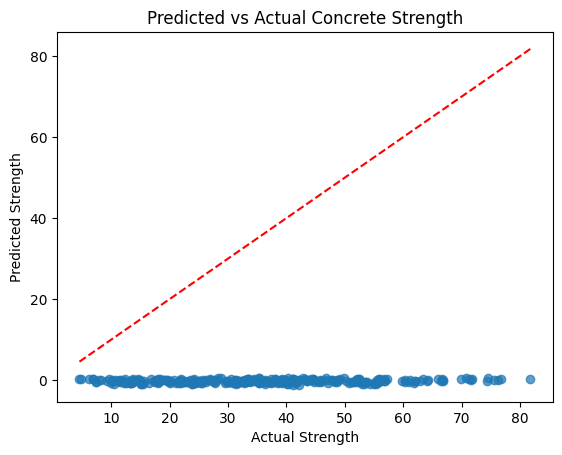

In [23]:
# Scatter: Predicted vs Actual

import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred_test, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Strength")
plt.ylabel("Predicted Strength")
plt.title("Predicted vs Actual Concrete Strength")
plt.show()

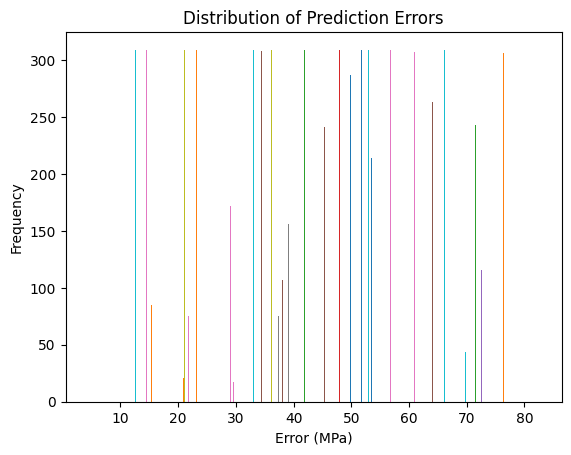

In [26]:
# Histogram: Prediction errors
residuals = y_test - y_pred_test
plt.hist(residuals, bins=20)
plt.title("Distribution of Prediction Errors")
plt.xlabel("Error (MPa)")
plt.ylabel("Frequency")
plt.show()